In [1]:
import os

import numpy as np
import pandas as pd

import librosa

ModuleNotFoundError: No module named 'pandas'

In [ ]:
train = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/intron-tts-train-public-28565.csv")
dev = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/intron-tts-dev-public-3330.csv")
test = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/intron-tts-test-public-4161.csv")

data = pd.concat([train, dev, test])

In [64]:
train.user_ids.nunique(), dev.user_ids.nunique(), test.user_ids.nunique()

(600, 76, 75)

In [65]:
data.user_ids.nunique(), data.duration.sum()/3600  # 751 speaker, 135 hours

(751, 135.66940027777778)

In [66]:
data[data.duration > 30.0].duration.sum() / 3600

6.012932222222221

In [67]:
len(data), data.audio_ids.nunique()

(36056, 36056)

In [68]:
# percentage of utterances with numbers

import re
def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

data["is_alnum"] = data.transcript.apply(lambda x: has_numbers(x))

In [69]:
data[data.is_alnum == True].duration.sum() / 3600 # 42 hours contain numbers

42.166316944444446

In [75]:
import re
# import unicode

# List of (regular expression, replacement) pairs for abbreviations:
_abbreviations = [(re.compile('\\b%s\\.' % x[0], re.IGNORECASE), x[1]) for x in [
    ('mrs', 'misess'),
    ('mr', 'mister'),
    ('ms', 'miss'),
    ('dr', 'doctor'),
    ('alh', 'alhaji'),
    ('engr', 'engineer'),
    ('prof', 'professor'),
    ('maj', 'major'),
    ('gen', 'general'),
    ('drs', 'doctors'),
    ('hon', 'honorable'),
]]

_punctuations = [
    ('(', ' close bracket '),
    (')', ' open bracket '),
    (':', ' colon '),
    (';', ' semi colon '),
    ('mrs ', 'misess '),
    ('mr ', 'mister '),
    ('ms ', 'miss '),
    ('prof ', 'professor '),
    ('dr ', 'doctor '),
    ('alh ', 'alhaji '),
    ('engr ', 'engineer '),
    ('maj ', 'major '),
    ('gen ', 'general '),
    ('drs ', 'doctors '),
    ('hon ', 'honorable '),
  
]

_punctuations = dict(_punctuations)
pattern = '|'.join(sorted(re.escape(k) for k in _punctuations))

def convert_to_ascii(text):
    return unidecode(text)

def lowercase(text):
    return text.lower()

def expand_abbreviations(text):
    for regex, replacement in _abbreviations:
        text = re.sub(regex, replacement, text)
    return text

def expand_punctuations(text):
    text = re.sub(pattern, lambda m: _punctuations.get(m.group(0).upper()), text, flags=re.IGNORECASE)
    return text

def english_cleaners(text):
    '''Pipeline for English text, including abbreviation expansion.'''
    # text = convert_to_ascii(text)
    text = lowercase(text)
    text = expand_abbreviations(text)
    text = expand_punctuations(text)
    return text

In [76]:
data["sentence"] = data.transcript.apply(english_cleaners)

In [72]:
from nemo_text_processing.text_normalization.normalize import Normalizer
text_normalizer = Normalizer(input_case="cased", lang="en")

[NeMo I 2024-02-16 01:06:31 tokenize_and_classify:87] Creating ClassifyFst grammars.


In [ ]:
data["sentence"] = data.sentence.apply(text_normalizer.normalize)

In [79]:
data["user_ids_num"] = pd.factorize(data["user_ids"])[0]

In [80]:
data["user_ids_num"].nunique() # 751 speakers

751

In [81]:
# remove files larger than 30 sec
data = data[data.duration <= 30.0]

# remove 3 files with audio_ids
data = data[data.audio_ids != "24bfceabfa102cc1c1926d2049f56bbf"]
data = data[data.audio_ids != "790cdbb7907d0112bc737f0b06282dde"]
data = data[data.audio_ids != "4bffcdb03a445616d70eb1a859ac52a5"]

In [82]:
data.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/temp/intron-tts-all-public-0000", index=False)


In [2]:
data = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/temp/intron-tts-all-public-0000")

In [5]:
data["user_ids_num"] = data.user_ids_num.apply(lambda x: x+109)

In [7]:
data_sh = data.sample(frac=1, random_state=0).reset_index(drop=True)
val = data_sh[0: 500]
test = data_sh[500: 1000]
train = data_sh[1000:]

In [11]:
with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/vits/filelists/afritts_audio_train.txt", "w+") as f4:
    for i, item in train.iterrows():
        print(f"DUMMY3/{item.audio_ids}.wav|{item.user_ids_num}|{item.sentence}", file=f4)

In [8]:
data[0:1].audio_ids

0    d9c56a91b8b5eb297e3f63f50e740f8b
Name: audio_ids, dtype: object

In [140]:
data[0:1].audio_paths.item()

'/AfriSpeech-TTS/train/8a4d0ddd-bebf-4df6-b63b-cf565b9fa3e1/97af9162eeacf6e593a8259f0db37735_6iHtbjwf.wav'

In [19]:
data.head()

,idx,user_ids,accent,age_group,gender,country,transcript,nchars,audio_ids,audio_paths,duration,neg_percent,origin,domain,split,expand_puncts
0,0,3610791f2fac24a3d35c4ffc75747ab6,Unknown,19-25,Female,ZA,It constituted a reaction against the precedin...,130,d9c56a91b8b5eb297e3f63f50e740f8b,/AfriSpeech-TTS/train/8a4d0ddd-bebf-4df6-b63b-...,17.421,0.00,african,general,train,False
1,1,2b7f63003f1bb607203aa3e4a7a22f3a,Swahili,19-25,Female,KE,"Catherine explained that Jarso, Mbarushimana, ...",142,88af6acc82c307abaa2f390cbe16ba87,/AfriSpeech-TTS/train/3679d557-a162-4835-93c6-...,8.236,0.69,african,general,train,False
2,2,2b7f63003f1bb607203aa3e4a7a22f3a,Swahili,19-25,Female,KE,"In the Ayieko Mr. Rebecca theory of gravity, h...",94,ec79dc90780ceea6bc847845d5c3370a,/AfriSpeech-TTS/train/3bac4989-69c5-4ffc-aad4-...,6.911,0.69,african,general,train,False
3,3,2b7f63003f1bb607203aa3e4a7a22f3a,Swahili,19-25,Female,KE,"If Lucifer were not God, would Kazir and his p...",144,2f407cfa632e6c207c8354ac2e3b8a14,/AfriSpeech-TTS/train/8cedb738-dab8-4e33-a004-...,11.544,0.69,african,general,train,False
4,4,2b7f63003f1bb607203aa3e4a7a22f3a,Swahili,19-25,Female,KE,"Johannes explained that Sir Ali, Marong, and h...",139,05d80f79b5e78cad6cd7d9fac031e57e,/AfriSpeech-TTS/train/3ba9c07d-d9fc-4780-a5d4-...,8.447,0.69,african,general,train,False


In [11]:
split = data # train, dev, test
speakers = pd.pivot_table(data, values="duration",
              columns=["user_ids"], aggfunc="sum").T.reset_index()

speakers["duration"] = speakers["duration"]# /3600

speakers = speakers.sort_values("duration", ascending=False).reset_index(drop=True)
speakers.head(20)

,user_ids,duration
0,2db35217e91d8889c6f6f4bdee66a52f,5015.518
1,73f971bbef38880a86ac97680ab5a7f8,4929.179
2,6b5cd67595796bf5489893b69755f43f,4834.860
3,1269ac57cb62784a2abeec0b904ed615,4796.768
4,b883f5d99b7dfc05fc7bbeca0f926e9f,4675.044
5,f5a8238265acd295b474e3b67cde1dd5,4665.078
6,96ca0f339408b47bbed4b4ed6fdc4460,4570.077
7,a35a75f5541bce9a15063660e1028215,4506.899
8,2a477d9f7d285736be740fe77180b9c0,4197.769
9,bef1fe43fb65dfc614c001baeef2a381,4123.003


In [13]:
speakers.tail(10)

,user_ids,duration
741,b545a4ca235a7b72688a1c0b3eb6bde6,8.181
742,2493cba45cdf00e461b67e78d518a910,7.706
743,633ea93e9a3eb22f92e6c522c11f1f52,7.559
744,df4a2d9487db6e98bf0d8825220f9bf4,7.391
745,ce339a60ecffc5a72db4bd2489d206cc,7.379
746,1a1b8d8aace7c96a29d6b32d74ed90fd,7.311
747,2bb382f192f6a57300bdb0ef6fbd8ad3,7.077
748,eb5df6c57ad707440696d8478e655d78,6.603
749,c73de2fe9d445a8d192c5aac49a0e0bb,5.773
750,6b76a3d99dd1fe093782ef197cb92816,5.035


In [22]:
accents = pd.pivot_table(data, values="duration",
              columns=["accent"], aggfunc="sum").T.reset_index()
accents["duration"] = accents["duration"]/3600
accents = accents.sort_values("duration", ascending=False).reset_index(drop=True)

In [35]:
accents.head(20) # don't forget to drop unknown accent

,accent,duration
0,Yoruba,31.673804
1,Hausa,30.752963
2,Unknown,10.263893
3,Swahili,10.220608
4,Igbo,8.898214
5,Zulu,6.432783
6,Ijaw,4.816897
7,Igala,3.125676
8,Idoma,2.964786
9,Afrikaans,2.078481


In [9]:
import librosa
import IPython.display as ipd

In [10]:
data[0:1].audio_paths.values.item()

'/AfriSpeech-TTS/train/8a4d0ddd-bebf-4df6-b63b-cf565b9fa3e1/97af9162eeacf6e593a8259f0db37735_6iHtbjwf.wav'

In [13]:
data[data.audio_paths == '/AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-9117e2ea592a/9b1f7d24a96824967ed3a1ae5d3c44cd_OWVB6wln.wav']

,idx,user_ids,accent,age_group,gender,country,transcript,nchars,audio_ids,audio_paths,duration,neg_percent,origin,domain,split,expand_puncts
833,1070,2db35217e91d8889c6f6f4bdee66a52f,Swahili,26-40,Male,KE,"Special guests: Mrs Rayna, Ms Seedy, Ms James,...",69,24bfceabfa102cc1c1926d2049f56bbf,/AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-...,13.178,0.08,african,general,train,True


In [ ]:
'/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/../AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-9117e2ea592a/9b1f7d24a96824967ed3a1ae5d3c44cd_OWVB6wln.wav'


In [12]:
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-9117e2ea592a/9b1f7d24a96824967ed3a1ae5d3c44cd_OWVB6wln.wav'

audio, sr = librosa.load(filepath, sr=16000)

ipd.Audio(audio, rate=sr)

/home/sogun/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-9117e2ea592a/9b1f7d24a96824967ed3a1ae5d3c44cd_OWVB6wln.wav'

In [92]:
audio.shape

(138704,)

In [76]:
sr

16000

In [77]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import librosa.display

# parameters
n_fft=1024
hop_length=256
window="hann"
# sr=16000
n_mels=80
fmin=0
fmax=8000
win_length=n_fft
power=1.0
n_iter=64

def plot_spec(spec, aspect=2):
    if spec is not None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = plt.imshow(spec, origin="lower",)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Colorbar")
        ax.set_aspect(aspect)
        plt.show()

In [78]:
audio.shape

(80560,)

In [120]:
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/b53792d173f1ac743819e81f240a3a07_ooKIycx6.wav'

audio, sr = librosa.load(filepath, sr=16000)

ref_mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, S=None, n_fft=n_fft, 
                                          hop_length=hop_length, 
                                          win_length=win_length, 
                                          window=window, power=power,
                                          n_mels=n_mels, fmin=fmin, fmax=fmax,)
# vocoder expects a log mel-spectrogram
eps = 1e-9
ref_log_mel = np.log(ref_mel_spec + eps)

In [121]:
ipd.Audio(audio, rate=sr)

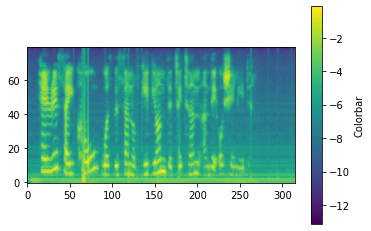

In [123]:
plot_spec(ref_log_mel,)

In [135]:
# denoised
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/b53792d173f1ac743819e81f240a3a07_ooKIycx6_dn.wav'

audio_dn, sr = librosa.load(filepath)

dn_mel_spec = librosa.feature.melspectrogram(y=audio_dn, sr=sr, S=None, n_fft=n_fft, 
                                          hop_length=hop_length, 
                                          win_length=win_length, 
                                          window=window, power=power,
                                          n_mels=n_mels, fmin=fmin, fmax=fmax,)
# vocoder expects a log mel-spectrogram
eps = 1e-9
dn_log_mel = np.log(dn_mel_spec + eps)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [125]:
ipd.Audio(audio, rate=sr)

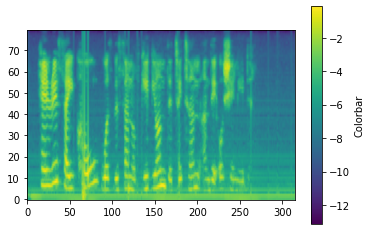

In [126]:
plot_spec(dn_log_mel,2.5)

In [2]:
!python /srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/utils/afrotts_remove_noise.py

Traceback (most recent call last):
  File "/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/utils/afrotts_remove_noise.py", line 6, in <module>
    from asteroid.models import BaseModel
ModuleNotFoundError: No module named 'asteroid'
